### Set the model configuration and load the necessary libraries.

In [ ]:
config = {
  "run_name": "cnn_58",
  "model":
    {
      "n_conv_layers": 4,
      "out_channels": [32, 64, 128, 256],
      "kernel_size": [3, 3, 3, 3],
      "stride": [1, 1, 1, 1],
      "padding": ["same", "same", "same", "same"],
      "activation": ["ReLU", "ReLU", "ReLU", "ReLU"],
      "dropout_rate": [0.2, 0.2, 0.2, 0.2],
      "pool_kernel_size": [2, 2, 2, 2],
      "num_flatten_features": 256,
      "use_batch_norm": True,
      "use_adaptive_pooling": True,
      "fc_layers": {
        "n_fc_layers": 3,
        "activation": ["ReLU", "ReLU", "ReLU"],
        "out_features": [256, 128, 64],
        "dropout_rate": [0.5, 0.3, 0.3]
      },
      "output_features": 29
    },
  "training":
    {
      "batch_size": 128,
      "epochs": 100,
      "optimizer": "Adam",
      "optimizer_params": {
        "lr": 0.0005,
      },
      "patience": 50,
      "num_workers": 4
    },
  "transformations": [
      {"name": "ConvertImageDtype"},
    ]
}

In [2]:
!pip install torchsummary

In [3]:
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
import torchvision
from torchvision.io import read_image
from torchvision.transforms.v2 import Compose, Resize, Normalize, ConvertImageDtype, RandomHorizontalFlip, RandomResizedCrop, ColorJitter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import json

import os
import numpy as np

import io
import sys
from torchsummary import summary

import os
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset

import torch
import torch.nn as nn

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2 as transforms
from torch.utils.data import default_collate

import logging
import torch
import wandb

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# import sys
# Add the directory containing your module to the Python path
# sys.path.append('/kaggle/input/dl-data/DL-Kaggle')
# sys.path.append('/kaggle/input/dl-data')

## Function definitons

### CNN.py

**Development of our class to generate CNNs in pytorch depending on the configuration we define.**

In [5]:
class CustomCNN(nn.Module):
    def __init__(self, model_config):
        super(CustomCNN, self).__init__()
        self.layers = nn.Sequential()  # Convolutional and pooling layers

        # Convolutional layer parameters
        n_conv_layers = model_config["n_conv_layers"]
        out_channels = model_config["out_channels"]
        kernel_size = model_config["kernel_size"]
        stride = model_config["stride"]
        padding = model_config["padding"]
        activation = model_config["activation"]
        dropout_rate = model_config["dropout_rate"]
        pool_kernel_size = model_config["pool_kernel_size"]

        in_channels = 3  # Assuming the input has 3 channels (e.g., RGB image)

        # Adding convolutional and pooling layers
        for i in range(n_conv_layers):
            # Convolutional layer
            self.layers.add_module(f"conv{i}", nn.Conv2d(in_channels, out_channels[i], kernel_size[i], stride[i], 0 if padding[i] == "valid" else 1))

            # Conditionally add batch normalization
            if model_config.get("use_batch_norm", False):
                self.layers.add_module(f"bn{i}", nn.BatchNorm2d(model_config["out_channels"][i]))
            
            # Activation
            if activation[i] in dir(nn):
                act_func = getattr(nn, activation[i])()
                self.layers.add_module(f"act{i}", act_func)
            
            # Pooling layer
            if pool_kernel_size[i]:
                self.layers.add_module(f"pool{i}", nn.MaxPool2d(kernel_size=pool_kernel_size[i]))
            
            # Dropout
            if dropout_rate[i] > 0:
                self.layers.add_module(f"dropout_2d{i}", nn.Dropout2d(dropout_rate[i]))

            in_channels = out_channels[i]

        # Optional adaptive pooling layer
        self.use_adaptive_pooling = model_config.get("use_adaptive_pooling", False)
        if self.use_adaptive_pooling:
            self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc_layers = nn.Sequential()
        fc_config = model_config["fc_layers"]
        n_fc_layers = fc_config["n_fc_layers"]
        fc_out_features = fc_config["out_features"]
        fc_dropout_rate = fc_config["dropout_rate"]
        activation = fc_config["activation"]
        num_features = model_config["num_flatten_features"]  # This needs to be calculated based on your input size and the architecture of your CNN

        for i in range(n_fc_layers):
            self.fc_layers.add_module(f"fc{i}", nn.Linear(num_features, fc_out_features[i]))
            if activation[i] in dir(nn):
                act_func = getattr(nn, activation[i])()
                self.fc_layers.add_module(f"act{i}", act_func)
            if fc_dropout_rate[i] > 0:
                self.fc_layers.add_module(f"dropout_fc{i}", nn.Dropout(fc_dropout_rate[i]))
            num_features = fc_out_features[i]

        # Output layer
        self.output_layer = nn.Linear(num_features, model_config["output_features"])  # Assuming output_features corresponds to the number of classes

    def forward(self, x):
        x = self.layers(x)
        if self.use_adaptive_pooling:
            x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # Flatten the output for the FC layers
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x

### MAMeDataset.py

**Function to load data.**

In [6]:
class MAMeDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): Pandas DataFrame containing annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(dataframe['Medium'].unique())

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = read_image(img_name)
        label = torch.tensor(self.dataframe.loc[idx, 'Label'])
        if self.transform:
            image = self.transform(image)
        return image, label

### Data Processing

In [7]:
def load_data(annotations_path, labels_path):    # Read the CSV files
    df = pd.read_csv(annotations_path)
    labels_df = pd.read_csv(labels_path, header=None, names=['Label', 'Medium'])

    # Merge to get string labels in the main DataFrame
    # df = df.merge(labels_df, left_on='Medium', right_on='Medium')

    # Encode the 'Medium' column
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Medium'])

    # Filter for the 'train' subset for demonstration
    train_df = df[df['Subset'] == 'train'].reset_index(drop=True)
    # Filter for the 'validation' subset for demonstration
    val_df = df[df['Subset'] == 'val'].reset_index(drop=True)
    # Filter for the 'test' subset for demonstration
    test_df = df[df['Subset'] == 'test'].reset_index(drop=True)

    return train_df, val_df, test_df

def get_transformations(config):
    transformation_list = []
    for transform_config in config["transformations"]:
        # Attempt to find the transformation class in torchvision.transforms
        TransformClass = getattr(transforms, transform_config["name"], None)
        # If not found in torchvision, try finding it in custom_transforms
        # if TransformClass is None:
        #     TransformClass = getattr(custom_transforms, transform_config["name"], None)
        
        if TransformClass is not None:
            # Remove the name key-value pair since it's not a parameter for the constructor
            params = {k: v for k, v in transform_config.items() if k != "name"}
            # Instantiate the transformation with the provided parameters
            transformation = TransformClass(**params)
            transformation_list.append(transformation)
        else:
            print(f"Warning: Transformation '{transform_config['name']}' not recognized.")

    return transforms.Compose(transformation_list)

def mixup_collate(num_classes, alpha):
    def collate_fn(batch):
        # Convert batch to default format
        batch = default_collate(batch)
        
        # Extract images and one-hot labels from the batch
        images, one_hot_labels = batch
        
        # Convert one-hot encoded labels to class numbers
        labels = one_hot_labels.argmax(dim=1)
        
        # Apply MixUp transformation
        mixup = transforms.MixUp(num_classes=num_classes, alpha=alpha)
        mixed_images, mixed_labels = mixup(images, labels)
        
        return mixed_images, mixed_labels
    
    return collate_fn

### Tools

In [8]:
# Training function
def train(model, device, train_loader, optimizer, loss_fn, epoch):
    model.train()
    train_loss = 0
    correct = 0

    collected_targets = []
    collected_preds = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = loss_fn(outputs, targets)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(targets.view_as(pred)).sum().item()

        # Collect targets and predictions
        collected_targets.append(targets.cpu())
        collected_preds.append(pred.cpu())

        if batch_idx % 20 == 0:
            logging.info(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {batch_loss.item():.6f}')

    # Concatenate all collected targets and predictions
    y_true = torch.cat(collected_targets).numpy()
    y_pred = torch.cat(collected_preds).numpy()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
        
    logging.info(f'Train set: Average loss: {train_loss:.4f}, Accuracy: {train_accuracy:.0f}%\n')
    
    return train_loss, train_accuracy, (y_true, y_pred)
    
# Evaluation function
def val(model, device, val_loader, loss_fn):
    model.eval()
    val_loss = 0
    correct = 0

    collected_targets = []
    collected_preds = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, targets)
            val_loss += batch_loss.item()

            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()

            # Collect targets and predictions
            collected_targets.append(targets.cpu().view(-1))
            collected_preds.append(pred.cpu().view(-1))

    # Concatenate all collected targets and predictions
    y_true = torch.cat(collected_targets).numpy()
    y_pred = torch.cat(collected_preds).numpy()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    logging.info(f'Val set: Average loss: {val_loss:.4f}, Accuracy: {val_accuracy:.0f}%\n')
    
    return val_loss, val_accuracy, (y_true, y_pred)

### Plots

*Functions for the results of a single model.*

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes, path, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix, and saves it to a specified path.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(12, 10))  # Adjust figure size
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, xticklabels=classes, yticklabels=classes)
    
    # Labels, title and ticks
    label_font = {'size':'12'}  # Adjust font size
    ax.set_xlabel('Predicted labels', fontdict=label_font)
    ax.set_ylabel('True labels', fontdict=label_font)
    ax.set_title(title, fontdict={'size':'15'})  # Adjust title and font size
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust tick size
    ax.tick_params(axis='both', which='minor', labelsize=10)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Save the plot to the specified path
    plt.savefig(path)
    plt.show()  # Close the plot to free up memory

def plot_losses(metrics, path):
    epochs = range(1, len(metrics["train_loss"]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_loss"], label='Training Loss', marker='o')
    plt.plot(epochs, metrics["val_loss"], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/loss_plot.png')
    plt.show()

def plot_accuracies(metrics, path):
    epochs = range(1, len(metrics["train_accuracy"]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_accuracy"], label='Training Accuracy', marker='o')
    plt.plot(epochs, metrics["val_accuracy"], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/accuracy_plot.png')
    plt.show()

def plot_accuracies_losses(metrics, path):
    epochs = range(1, len(metrics["train_accuracy"]) + 1)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(epochs, metrics["train_accuracy"], label='Training Accuracy',  color='#4c72b0')  
    ax1.plot(epochs, metrics["val_accuracy"], label='Validation Accuracy',  color='#dd8452')  
    ax1.set_ylabel('Accuracy %', color='black')
    ax1.set_xlabel('Epochs')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='lower left')

    ax2 = ax1.twinx()  
    ax2.plot(epochs, metrics["train_loss"], label='Training Loss',   linestyle='--', color='#4c72b0')  
    ax2.plot(epochs, metrics["val_loss"], label='Validation Loss',  linestyle='--', color='#dd8452')  
    ax2.set_ylabel('Loss', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper left')
    
    ax1.set_yticks(np.linspace(*(ax1.get_yticks()[[0,-1]]),8))
    ax2.set_yticks(np.linspace(*(ax2.get_yticks())[[0,-1]],8))
    
    plt.title('Loss and Accuracy Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{path}/accuracy_loss_plot.png')
    plt.show()

*Functions for results from more than one model.*

In [10]:
def plot_losses_all(metrics, path):
    plt.figure(figsize=(10, 6))
    custom = {"axes.edgecolor": "black"}
    sns.set_style("whitegrid", rc = custom)
    sns.lineplot(data=metrics,x="Epoch",y="train_loss", label='Training Loss', color='#4c72b0')
    sns.lineplot(data=metrics,x="Epoch",y="val_loss", label='Validation Loss', color='#dd8452')
    plt.title('Train and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{path}/loss_plot.png')
    plt.show()

def plot_accuracies_all(metrics, path):
       
    plt.figure(figsize=(10, 6))
    custom = {"axes.edgecolor": "black"}
    sns.set_style("whitegrid", rc = custom)
    sns.lineplot(data=metrics,x="Epoch",y="train_accuracy", label='Training Accuracy', color='#4c72b0')
    sns.lineplot(data=metrics,x="Epoch",y="val_accuracy", label='Validation Accuracy', color='#dd8452')
    plt.title('Train and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.legend()
    plt.savefig(f'{path}/accuracy_plot.png')
    plt.show()

def plot_accuracies_losses_all(metrics, path):   
    epochs = range(1, len(metrics["train_accuracy"]) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    custom = {"axes.edgecolor": "black"}
    sns.set_style("whitegrid", rc = custom)

    sns.lineplot(data=metrics,x="Epoch",y="train_accuracy", label='Training Accuracy', color='#4c72b0',axes=ax1)
    sns.lineplot(data=metrics,x="Epoch",y="val_accuracy",  label='Validation Accuracy', color='#dd8452',axes=ax1)
    ax1.set_ylabel('Accuracy %', color='black')
    ax1.set_xlabel('Epochs')
    ax1.tick_params(axis='y', labelcolor='black')
    

    ax2 = ax1.twinx()
    sns.lineplot(data=metrics,x="Epoch",y="train_loss", label='Training Loss', linestyle='--', color='#4c72b0')
    sns.lineplot(data=metrics,x="Epoch",y="val_loss", label='Validation Loss', linestyle='--', color='#dd8452')
    ax2.set_ylabel('Loss', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper left')
    
    ax1_ticks = np.arange(*(ax1.get_yticks()[[0,-1]])+[0,5],5)
    ax1.set_yticks(ax1_ticks)
    ax2_ticks = []
    ax1_1, ax1_2 = (ax1.get_yticks())[[0,-1]]
    ax2_1, ax2_2 = (ax2.get_yticks())[[0,-1]]
    for i in ax1_ticks: 
        ax2_ticks.append(i/(ax1_2-ax1_1)*(ax2_2-ax2_1)+ax2_1)
    ax2.set_yticks(ax2_ticks)
    sns.move_legend(ax1,'lower left')
    
    plt.title('Loss and Accuracy Plot')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'{path}/accuracy_loss_plot.png')
    plt.show()

### Function to set the seed

In [11]:
import torch
import numpy as np
import random
import os

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)  # Set numpy seed
    torch.manual_seed(seed_value)  # Set torch seed for CPU
    random.seed(seed_value)  # Set Python seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set Python hash seed    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value) # Set torch seed for GPU

### Logging Functions

In [12]:
import os
import logging
import sys
from datetime import datetime
import json

def setup_logging(config):
    # Create a unique directory for the current run
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    run_dir = os.path.join('results', timestamp)
    os.makedirs(run_dir, exist_ok=True)
    
    # Set up logging to save to a file in the unique directory
    log_file = os.path.join(run_dir, 'training.log')

    # Remove all handlers associated with the root logger object.
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S',
                        handlers=[logging.FileHandler(log_file), logging.StreamHandler(sys.stdout)])
    logging.info("Logging is set up.")
    
    # Save a copy of the config file in the unique directory
    config_copy_path = os.path.join(run_dir, 'config.json')
    with open(config_copy_path, 'w') as config_file:
        json.dump(config, config_file, indent=4)

    return run_dir

In [13]:
# Load datasets 
kaggle_path = '/kaggle/input/dl-data/DL-Kaggle/DL-Kaggle/'
data_path = kaggle_path + 'data/data_256'
annotations_path = kaggle_path + 'data/MAMe_metadata/MAMe_dataset.csv'
labels_path = kaggle_path + 'data/MAMe_metadata/MAMe_labels.csv'
model_state_dict_path = '/kaggle/input/dl-data/best_model_0.0005.pth'

In [14]:
# set_seed(42)

# Set the device
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS as device")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using CUDA as device")
# else:
#     device = torch.device("cpu")
#     print("Using CPU as device")
    
# Instantiate the model
# model = CustomCNN(config['model']).to(device)
# summary(model, input_size=(3, 256, 256))

### Training

**The following code is executed when you want to train the model. In this case, it's left commented out since the model was first trained with 300 epochs using a learning rate of 0.001, and then 100 more epochs with a learning rate of 0.0005.**

In [15]:
# Instantiate the model
device = torch.device("cuda")
model = CustomCNN(config['model']).to(device)

# Temporary redirect stdout to capture the summary
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

summary(model, input_size=(3, 256, 256))

# Get the "printed" content
model_summary = buffer.getvalue()

# Restore stdout
sys.stdout = old_stdout

# Now you can log the summary or print it
print(model_summary)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
         Dropout2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
       BatchNorm2d-7         [-1, 64, 128, 128]             128
              ReLU-8         [-1, 64, 128, 128]               0
         MaxPool2d-9           [-1, 64, 64, 64]               0
        Dropout2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [16]:
# metrics_all = pd.DataFrame(columns=["Seed","Epoch","train_accuracy","val_accuracy","train_loss","val_loss"])

# for s in [42]:#,123,24]:
    
#     set_seed(s)

#     # Set the device
#     if torch.backends.mps.is_available():
#         device = torch.device("mps")
#         print("Using MPS as device")
#     elif torch.cuda.is_available():
#         device = torch.device("cuda")
#         print("Using CUDA as device")
#     else:
#         device = torch.device("cpu")
#         print("Using CPU as device")

#     log_dir = setup_logging(config)

#     logging.info("Model summary:\n" + model_summary)

#     training_config = config["training"]

#     # Data loading and preprocessing
#     transform = get_transformations(config)

#     train_df, val_df, test_df = load_data(annotations_path, labels_path)
    
#     val_test_transform = Compose([
#         ConvertImageDtype(),
#     ])

#     train_dataset = MAMeDataset(dataframe=train_df, root_dir=data_path, transform=transform)
#     val_dataset = MAMeDataset(dataframe=val_df, root_dir=data_path, transform=val_test_transform)
#     test_dataset = MAMeDataset(dataframe=test_df, root_dir=data_path, transform=val_test_transform)

#     # Create a DataLoader
#     train_dataloader = DataLoader(train_dataset, batch_size=training_config['batch_size'], shuffle=True, num_workers=training_config['num_workers'], persistent_workers=True)
#     val_dataloader = DataLoader(val_dataset, batch_size=training_config['batch_size'], shuffle=True, num_workers=0)
#     test_dataloader = DataLoader(test_dataset, batch_size=training_config['batch_size'], shuffle=True, num_workers=0)
    
#     # Model setup and load
#     model = CustomCNN(config["model"]).to(device)
#     model.load_state_dict(torch.load(model_state_dict_path))

#     # Loss and optimizer
#     loss_fn = nn.CrossEntropyLoss()  # Adjust based on your output layer and task
#     optimizer = getattr(optim, training_config["optimizer"])(model.parameters(), **training_config["optimizer_params"])
#     # Main training loop

#     metrics = {
#         "train_loss": [],
#         "train_accuracy": [],
#         "val_loss": [],
#         "val_accuracy": []
#     }

#     early_stopping_counter = 0
#     best_loss = np.inf
#     best_epoch = 0  # To keep track of the best epoch

#     # Variables to store best performance metrics for plotting
#     best_y_true = None
#     best_y_pred = None

#     for epoch in range(1, config["training"]["epochs"] + 1):

#         train_loss, train_accuracy, _ = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
#         val_loss, val_accuracy, (y_true, y_pred) = val(model, device, val_dataloader, loss_fn)

#         # Append the metrics for the current epoch
#         metrics["train_loss"].append(train_loss)
#         metrics["train_accuracy"].append(train_accuracy)
#         metrics["val_loss"].append(val_loss)
#         metrics["val_accuracy"].append(val_accuracy)

#         # Check for test loss improvement
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_epoch = epoch
#             early_stopping_counter = 0  # Reset counter on improvement
#             # Optionally, save the model here as the best model so far
#             torch.save(model.state_dict(), log_dir + '/best_model.pth')
#             # Store best performance metrics for confusion matrix
#             best_y_true = y_true
#             best_y_pred = y_pred
#         else:
#             early_stopping_counter += 1

#         # Check if early stopping criteria are met
#         if early_stopping_counter >= config["training"]["patience"]:
#             logging.info(f"Stopping early at epoch {epoch} due to no improvement in test loss.")
#             break  # Exit the training loop

#     classes_list = test_dataloader.dataset.classes
#     plot_dir = log_dir+'/plots'
#     os.makedirs(plot_dir, exist_ok=True)
    
#     # After the loop, plot the confusion matrix for the best model
#     if best_y_true is not None and best_y_pred is not None:
#         plot_confusion_matrix(best_y_true, best_y_pred, classes_list, path=plot_dir+'/best_cm.png')
#         logging.info(f"Plotted confusion matrix for the best model at epoch {best_epoch}.")

#         # Convert numpy arrays to lists for JSON serialization
#         metrics["best_y_true"] = best_y_true.tolist()
#         metrics["best_y_pred"] = best_y_pred.tolist()

#     plot_losses(metrics, plot_dir)
#     plot_accuracies(metrics, plot_dir)
#     plot_accuracies_losses(metrics, plot_dir)

#     with open(log_dir+'/metrics.json', 'w') as f:
#         json.dump(metrics, f)
    
#     # Save metrics in metrics_all
#     metrics_df = pd.DataFrame({
#         "Seed": [s] * len(metrics["train_accuracy"]),
#         "Epoch": list(range(1, len(metrics["train_accuracy"]) + 1)),
#         "train_accuracy": metrics["train_accuracy"],
#         "val_accuracy": metrics["val_accuracy"],
#         "train_loss": metrics["train_loss"],
#         "val_loss": metrics["val_loss"]
#     })
#     metrics_all = pd.concat([metrics_all, metrics_df], ignore_index=True)

# # Plot Average Results
# all_results = os.path.join('results', "All_Results")
# if not os.path.exists(all_results):
#     os.makedirs(all_results)

# plot_losses_all(metrics_all,all_results)
# plot_accuracies_all(metrics_all,all_results)
# plot_accuracies_losses_all(metrics_all,all_results)

### Results Evaluation

In [19]:
set_seed(42)

model_state_dict_path = '/kaggle/input/dl-data/best_model_0.0005.pth'
# Set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS as device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA as device")
else:
    device = torch.device("cpu")
    print("Using CPU as device")

log_dir = setup_logging(config)

logging.info("Model summary:\n" + model_summary)

training_config = config["training"]

# Data loading and preprocessing
transform = get_transformations(config)

train_df, val_df, test_df = load_data(annotations_path, labels_path)

val_test_transform = Compose([
    ConvertImageDtype(),
])

train_dataset = MAMeDataset(dataframe=train_df, root_dir=data_path, transform=transform)
val_dataset = MAMeDataset(dataframe=val_df, root_dir=data_path, transform=val_test_transform)
test_dataset = MAMeDataset(dataframe=test_df, root_dir=data_path, transform=val_test_transform)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=training_config['batch_size'], shuffle=True, num_workers=training_config['num_workers'], persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=training_config['batch_size'], shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=training_config['batch_size'], shuffle=True, num_workers=0)

# Model setup and load
model = CustomCNN(config["model"]).to(device)
model.load_state_dict(torch.load(model_state_dict_path))


# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()  # Adjust based on your output layer and task
optimizer = getattr(optim, training_config["optimizer"])(model.parameters(), **training_config["optimizer_params"])

def test(model, device, val_loader, name, loss_fn):
    model.eval()
    val_loss = 0
    correct = 0

    collected_targets = []
    collected_preds = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, targets)
            val_loss += batch_loss.item()

            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()

            # Collect targets and predictions
            collected_targets.append(targets.cpu().view(-1))
            collected_preds.append(pred.cpu().view(-1))

    # Concatenate all collected targets and predictions
    y_true = torch.cat(collected_targets).numpy()
    y_pred = torch.cat(collected_preds).numpy()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    logging.info(f'{name} set: Average loss: {val_loss:.5f}, Accuracy: {val_accuracy:.5f}%\n')
    
    return val_loss, val_accuracy, (y_true, y_pred)


train_loss, train_accuracy, (train_y_true, train_y_pred) = test(model, device, train_dataloader,"Train", loss_fn)
val_loss, val_accuracy, (val_y_true, val_y_pred) = test(model, device, val_dataloader,"Validation", loss_fn)
test_loss, test_accuracy, (test_y_true, test_y_pred) = test(model, device, test_dataloader,"Test", loss_fn)

Using CUDA as device
2024-04-12 16:08:59 - INFO - Logging is set up.
2024-04-12 16:08:59 - INFO - Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
         Dropout2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
       BatchNorm2d-7         [-1, 64, 128, 128]             128
              ReLU-8         [-1, 64, 128, 128]               0
         MaxPool2d-9           [-1, 64, 64, 64]               0
        Dropout2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
      BatchNorm2d-12          [-1, 128, 64, 64]       

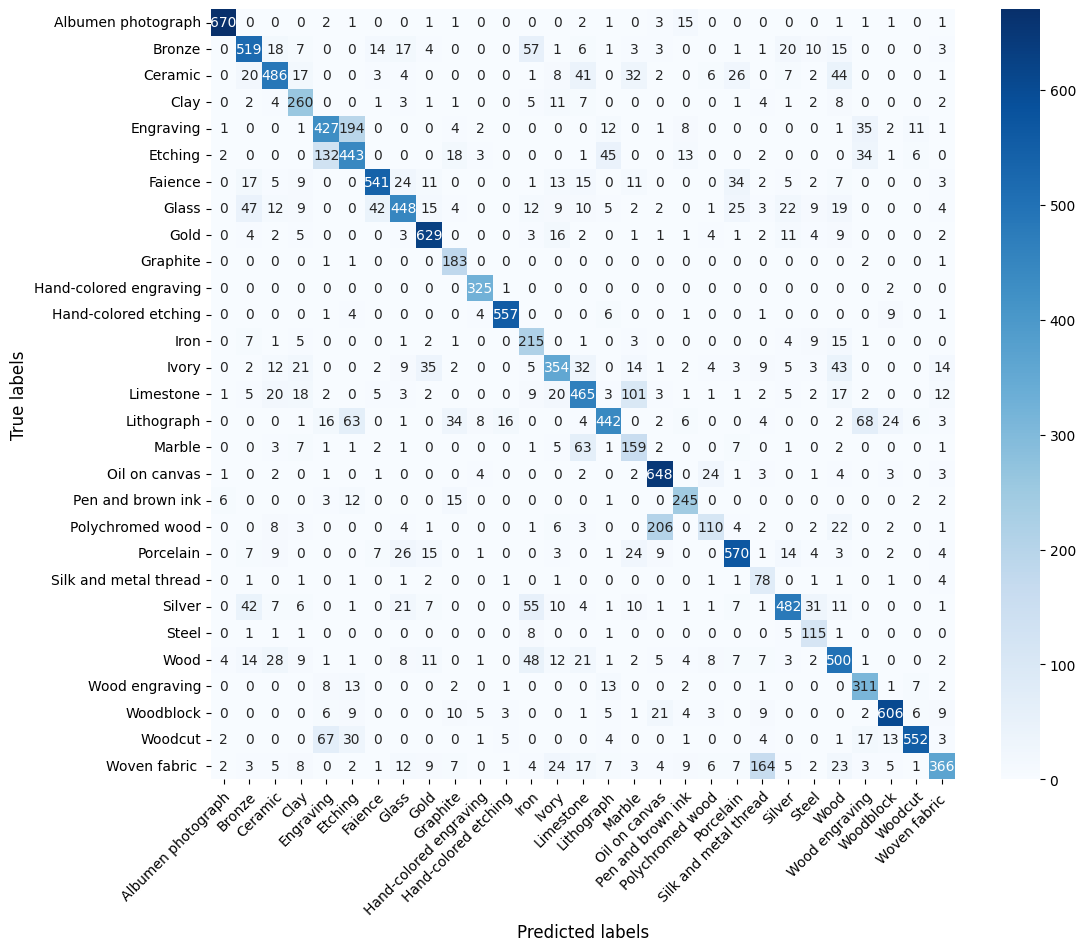

In [30]:
classes_list = test_dataloader.dataset.classes
plot_dir = log_dir+'/plots'
os.makedirs(plot_dir, exist_ok=True)
# list(range(1,len(classes_list)+1))
plot_confusion_matrix(test_y_true, test_y_pred,classes_list, path=plot_dir+'/best_cm.png')

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

num_classes = len(np.unique(train_y_true))


# Calculate accuracy for each class
def calculate_class_accuracy(y_true, y_pred, num_classes):
    class_accuracy = []
    for cls in range(num_classes):
        indices = np.where(y_true == cls)[0]
        class_accuracy.append(accuracy_score(y_true[indices], y_pred[indices]))
    return class_accuracy

train_class_accuracy = calculate_class_accuracy(train_y_true, train_y_pred, num_classes)
val_class_accuracy = calculate_class_accuracy(val_y_true, val_y_pred, num_classes)
test_class_accuracy = calculate_class_accuracy(test_y_true, test_y_pred, num_classes)

# Calculate loss entropy for each dataset
train_loss_entropy = -train_loss
val_loss_entropy = -val_loss
test_loss_entropy = -test_loss

# Calculate F1 score for each class
train_f1_score = f1_score(train_y_true, train_y_pred, average=None)
val_f1_score = f1_score(val_y_true, val_y_pred, average=None)
test_f1_score = f1_score(test_y_true, test_y_pred, average=None)

# Calculate macro, micro, and weighted metrics
train_macro_f1_score = f1_score(train_y_true, train_y_pred, average='macro')
train_micro_f1_score = f1_score(train_y_true, train_y_pred, average='micro')
train_weighted_f1_score = f1_score(train_y_true, train_y_pred, average='weighted')

val_macro_f1_score = f1_score(val_y_true, val_y_pred, average='macro')
val_micro_f1_score = f1_score(val_y_true, val_y_pred, average='micro')
val_weighted_f1_score = f1_score(val_y_true, val_y_pred, average='weighted')

test_macro_f1_score = f1_score(test_y_true, test_y_pred, average='macro')
test_micro_f1_score = f1_score(test_y_true, test_y_pred, average='micro')
test_weighted_f1_score = f1_score(test_y_true, test_y_pred, average='weighted')

# Create a dictionary with the metrics
metrics_dict = {
    'Class': classes_list + ['Macro', 'Micro', 'Weighted'],
    'Accuracy (Train)': train_class_accuracy + [None, None, None],
    'Accuracy (Validation)': val_class_accuracy + [None, None, None],
    'Accuracy (Test)': test_class_accuracy + [None, None, None],
    'F1 Score (Train)': list(train_f1_score) + [train_macro_f1_score, train_micro_f1_score, train_weighted_f1_score],
    'F1 Score (Validation)': list(val_f1_score) + [val_macro_f1_score, val_micro_f1_score, val_weighted_f1_score],
    'F1 Score (Test)': list(test_f1_score) + [test_macro_f1_score, test_micro_f1_score, test_weighted_f1_score]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Display DataFrame
print(metrics_df)

                     Class  Accuracy (Train)  Accuracy (Validation)  \
0       Albumen photograph          0.991429                   0.94   
1                   Bronze          0.852857                   0.74   
2                  Ceramic          0.825714                   0.72   
3                     Clay          0.917143                   0.86   
4                Engraving          0.638571                   0.48   
5                  Etching          0.710000                   0.52   
6                  Faience          0.821429                   0.76   
7                    Glass          0.810000                   0.66   
8                     Gold          0.942857                   0.88   
9                 Graphite          0.988571                   0.98   
10  Hand-colored engraving          0.995714                   0.96   
11    Hand-colored etching          0.992857                   0.96   
12                    Iron          0.911429                   0.90   
13    

In [42]:
print(metrics_df.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 & Class & Accuracy (Train) & Accuracy (Validation) & Accuracy (Test) & F1 Score (Train) & F1 Score (Validation) & F1 Score (Test) \\
\midrule
0 & Albumen photograph & 0.991429 & 0.940000 & 0.957143 & 0.985096 & 0.921569 & 0.964723 \\
1 & Bronze & 0.852857 & 0.740000 & 0.741429 & 0.852857 & 0.747475 & 0.746226 \\
2 & Ceramic & 0.825714 & 0.720000 & 0.694286 & 0.840727 & 0.800000 & 0.734694 \\
3 & Clay & 0.917143 & 0.860000 & 0.830671 & 0.887353 & 0.834951 & 0.741797 \\
4 & Engraving & 0.638571 & 0.480000 & 0.610000 & 0.673700 & 0.457143 & 0.624269 \\
5 & Etching & 0.710000 & 0.520000 & 0.632857 & 0.668011 & 0.485981 & 0.600271 \\
6 & Faience & 0.821429 & 0.760000 & 0.772857 & 0.860135 & 0.817204 & 0.820318 \\
7 & Glass & 0.810000 & 0.660000 & 0.640000 & 0.845638 & 0.733333 & 0.696734 \\
8 & Gold & 0.942857 & 0.880000 & 0.898571 & 0.945559 & 0.846154 & 0.870588 \\
9 & Graphite & 0.988571 & 0.980000 & 0.973404 & 0.940857 & 0.875000 & 0.778723 \\
10 & Ha

### Datasets Analysis

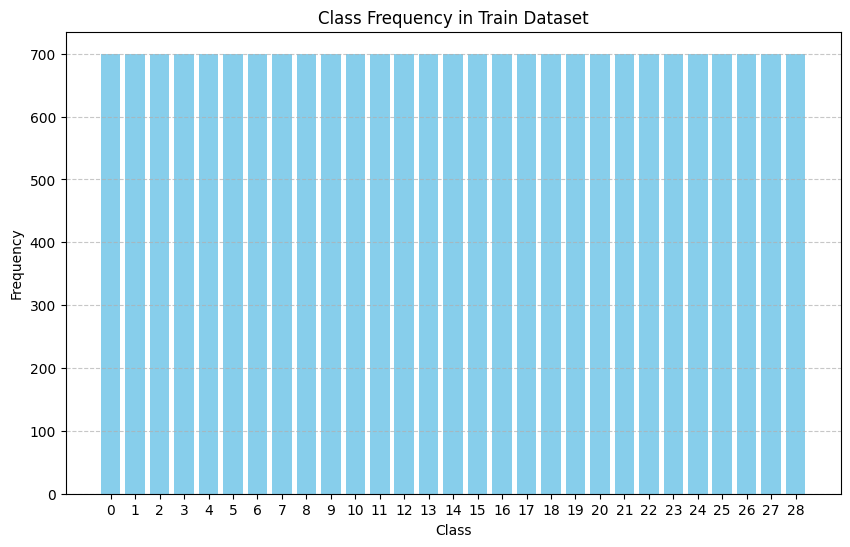

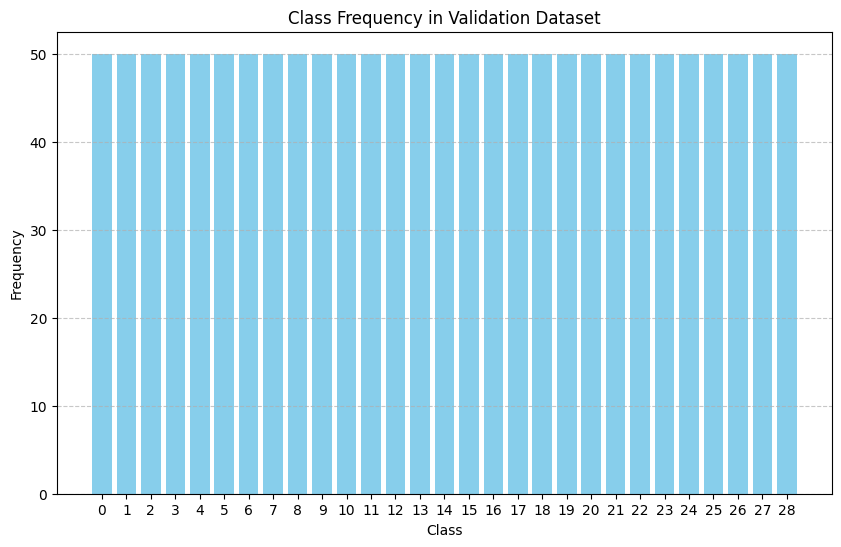

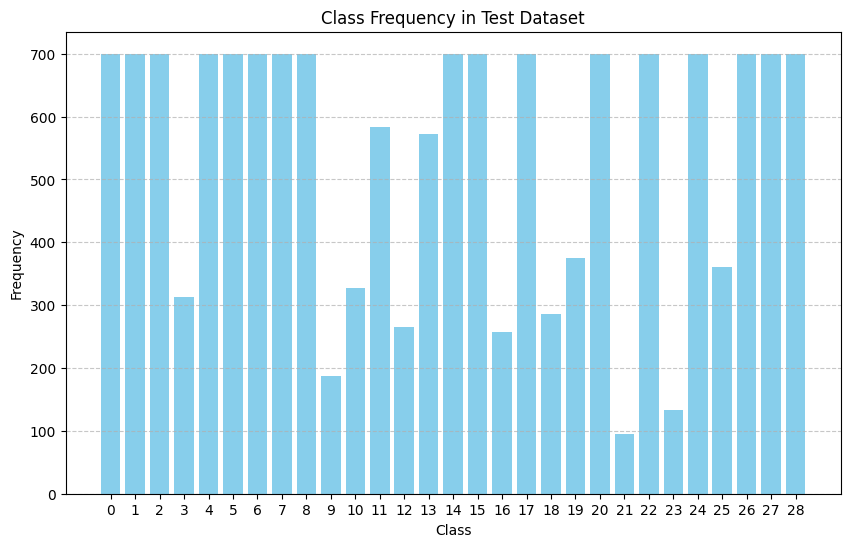

Number of instances in Train DataLoader: 20300
Number of instances in Validation DataLoader: 1450
Number of instances in Test DataLoader: 15657


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot class frequency
def plot_class_frequency(labels, dataset_name):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(unique_classes, class_counts, color='skyblue')
    plt.title(f'Class Frequency in {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(unique_classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot class frequency for each dataset
plot_class_frequency(train_y_true, "Train Dataset")
plot_class_frequency(val_y_true, "Validation Dataset")
plot_class_frequency(test_y_true, "Test Dataset")

# Print number of instances in each dataloader
print("Number of instances in Train DataLoader:", len(train_y_true))
print("Number of instances in Validation DataLoader:", len(val_y_true))
print("Number of instances in Test DataLoader:", len(test_y_true))